In [8]:
# library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, make_scorer, auc, precision_recall_curve
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Random Over Sample in training dataset
from imblearn.over_sampling import SMOTE, ADASYN
import datetime

In [390]:
def evaluate_metrics(y_val, y_pred):
    mmc = matthews_corrcoef(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    print("Evaluation Score")
    print("MMC ", mmc)
    print("Accuracy ", acc)
    print("F1 ", f1)
    print("Precision ", precision)
    print("Recall ", recall)

def train_evaluate(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    evaluate_metrics(y_val, y_pred)
    return model

def pr_auc_score(y_val, y_pred):
    precision, recall, thr = precision_recall_curve(y_val, y_pred)
    pr_auc = auc(recall, precision)
    return pr_auc

precision_recall_auc_score = make_scorer(pr_auc_score)

def cross_validation(model, X, y):
#     score = cross_val_score(model, X, y, cv=5, scoring=precision_recall_auc_score).mean()
    score = cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean()
    score = np.array(score)
    print("Cross Val Score :", score)
    
def week_number_of_month(date):
    return (date.isocalendar()[1] - date.replace(day=1).isocalendar()[1] +1 )

def transform_log1p(df, feature):
    new_features = feature + "_log1p"
    df[new_features] = np.log1p(df[feature])
    
def all_never(x):
    if (x.last_login_day == 'Never login') & (x.last_open_day == 'Never open') & (x.last_checkout_day == 'Never checkout'):
        return 1
    else: 
        return 0

def login_never_open_checkout(x):
    if (x.last_login_day != 'Never login') & (x.last_open_day == 'Never open') & (x.last_checkout_day == 'Never checkout'):
        return 1
    else: 
        return 0
    
def login_open_never_checkout(x):
    if (x.last_login_day != 'Never login') & (x.last_open_day != 'Never open') & (x.last_checkout_day == 'Never checkout'):
        return 1
    else: 
        return 0

In [391]:
# read files
train = pd.read_csv("../input/open-shopee-code-league-marketing-analytics/train.csv")
test = pd.read_csv("../input/open-shopee-code-league-marketing-analytics/test.csv")

# inconsintency
train['is_inconsistent_open'] = 0
train['is_inconsistent_login'] = 0
train['is_inconsistent_checkout'] = 0

train.loc[(train.last_open_day == 'Never open') & (train.open_count_last_10_days > 0), 'is_inconsistent_open'] = 1
train.loc[(train.last_open_day == 'Never open') & (train.open_count_last_30_days > 0), 'is_inconsistent_open'] = 1
train.loc[(train.last_open_day == 'Never open') & (train.open_count_last_60_days > 0), 'is_inconsistent_open'] = 1

train.loc[(train.last_login_day == 'Never login') & (train.login_count_last_10_days > 0), 'is_inconsistent_login'] = 1
train.loc[(train.last_login_day == 'Never login') & (train.login_count_last_30_days > 0), 'is_inconsistent_login'] = 1
train.loc[(train.last_login_day == 'Never login') & (train.login_count_last_60_days > 0), 'is_inconsistent_login'] = 1

train.loc[(train.last_checkout_day == 'Never checkout') & (train.checkout_count_last_10_days > 0), 'is_inconsistent_checkout'] = 1
train.loc[(train.last_checkout_day == 'Never checkout') & (train.checkout_count_last_30_days > 0), 'is_inconsistent_checkout'] = 1
train.loc[(train.last_checkout_day == 'Never checkout') & (train.checkout_count_last_60_days > 0), 'is_inconsistent_checkout'] = 1

train['is_inconsistent_all'] = train['is_inconsistent_open'] | train['is_inconsistent_login'] | train['is_inconsistent_checkout']

test['is_inconsistent_open'] = 0
test['is_inconsistent_login'] = 0
test['is_inconsistent_checkout'] = 0

test.loc[(test.last_open_day == 'Never open') & (test.open_count_last_10_days > 0), 'is_inconsistent_open'] = 1
test.loc[(test.last_open_day == 'Never open') & (test.open_count_last_30_days > 0), 'is_inconsistent_open'] = 1
test.loc[(test.last_open_day == 'Never open') & (test.open_count_last_60_days > 0), 'is_inconsistent_open'] = 1

test.loc[(test.last_login_day == 'Never login') & (test.login_count_last_10_days > 0), 'is_inconsistent_login'] = 1
test.loc[(test.last_login_day == 'Never login') & (test.login_count_last_30_days > 0), 'is_inconsistent_login'] = 1
test.loc[(test.last_login_day == 'Never login') & (test.login_count_last_60_days > 0), 'is_inconsistent_login'] = 1

test.loc[(test.last_checkout_day == 'Never checkout') & (test.checkout_count_last_10_days > 0), 'is_inconsistent_checkout'] = 1
test.loc[(test.last_checkout_day == 'Never checkout') & (test.checkout_count_last_30_days > 0), 'is_inconsistent_checkout'] = 1
test.loc[(test.last_checkout_day == 'Never checkout') & (test.checkout_count_last_60_days > 0), 'is_inconsistent_checkout'] = 1

test['is_inconsistent_all'] = test['is_inconsistent_open'] | test['is_inconsistent_login'] | test['is_inconsistent_checkout']

# binary activities
train['login_never_open_checkout'] = train.apply(lambda x: login_never_open_checkout(x), axis=1)
test['login_never_open_checkout'] = test.apply(lambda x: login_never_open_checkout(x), axis=1)

# one-hot country code
train['country_4'] = train.country_code.apply(lambda x: 1 if x == 4 else 0)
train['country_5'] = train.country_code.apply(lambda x: 1 if x == 5 else 0)
train['country_6'] = train.country_code.apply(lambda x: 1 if x == 6 else 0)
train['country_7'] = train.country_code.apply(lambda x: 1 if x == 7 else 0)

# encode never activities
train.loc[train.last_open_day == 'Never open', 'last_open_day'] = 1000
train.last_open_day = train.last_open_day.astype(int)
train.loc[train.last_login_day == 'Never login', 'last_login_day'] = 2000
train.last_login_day = train.last_login_day.astype(int)
train.loc[train.last_checkout_day == 'Never checkout', 'last_checkout_day'] = 1500
train.last_checkout_day = train.last_checkout_day.astype(int)
train.loc[train.last_login_day > 18000, 'last_login_day'] = 2000  # the last login day that bigger than 18k is users who never login

# interaction - difference
train['diff_open_count_last3010'] = train.open_count_last_30_days - train.open_count_last_10_days
train['diff_open_count_last6010'] = train.open_count_last_60_days - train.open_count_last_10_days
train['diff_open_count_last6030'] = train.open_count_last_60_days - train.open_count_last_30_days

# count per day 2
train['diff_open_count_last3010_perday'] = train.diff_open_count_last3010 / 20
train['diff_open_count_last6010_perday'] = train.diff_open_count_last6010 / 50

# one-hot country code
# test['country_1'] = test.country_code.apply(lambda x: 1 if x == 1 else 0)
test['country_4'] = test.country_code.apply(lambda x: 1 if x == 4 else 0)
test['country_5'] = test.country_code.apply(lambda x: 1 if x == 5 else 0)
test['country_6'] = test.country_code.apply(lambda x: 1 if x == 6 else 0)
test['country_7'] = test.country_code.apply(lambda x: 1 if x == 7 else 0)

# encode never activities
test.loc[test.last_open_day == 'Never open', 'last_open_day'] = 1000
test.last_open_day = test.last_open_day.astype(int)
test.loc[test.last_login_day == 'Never login', 'last_login_day'] = 2000
test.last_login_day = test.last_login_day.astype(int)
test.loc[test.last_checkout_day == 'Never checkout', 'last_checkout_day'] = 1500
test.last_checkout_day = test.last_checkout_day.astype(int)

# interaction - difference
test['diff_open_count_last3010'] = test.open_count_last_30_days - test.open_count_last_10_days
test['diff_open_count_last6010'] = test.open_count_last_60_days - test.open_count_last_10_days
test['diff_open_count_last6030'] = test.open_count_last_60_days - test.open_count_last_30_days

# count per day 2
test['diff_open_count_last3010_perday'] = test.diff_open_count_last3010 / 20
test['diff_open_count_last6010_perday'] = test.diff_open_count_last6010 / 50

# impute nan
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)
test = test.replace([np.inf, -np.inf], np.nan)
test = test.fillna(0)

# transform    
transform_log1p(train, 'open_count_last_60_days')
transform_log1p(train, 'open_count_last_30_days')
transform_log1p(train, 'open_count_last_10_days')
transform_log1p(train, 'checkout_count_last_60_days')

transform_log1p(test, 'open_count_last_60_days')
transform_log1p(test, 'open_count_last_30_days')
transform_log1p(test, 'open_count_last_10_days')
transform_log1p(test, 'checkout_count_last_60_days')

# drop unnecessary columns
train = train.drop(['row_id', 'grass_date'], axis=1)
test = test.drop(['row_id', 'grass_date'], axis=1)

users_label = []
for i in range(20):
    users_label.append(str(i))

# create user_id bin
train['user_id_bin'] = pd.cut(train.user_id, bins=20, labels=users_label)
test['user_id_bin'] = pd.cut(test.user_id, bins=20, labels=users_label)

features = train.columns.tolist()
features.remove('user_id_bin')
target = 'user_id_bin'

# perform oversample for only minority class
sampler = ADASYN(sampling_strategy='minority',random_state=41) # so the minority will have ratio 1 with majority
X_train, y_train = sampler.fit_sample(train[features], train[target])
train = pd.concat([X_train, y_train], axis=1)

dropped_features = ['checkout_count_last_30_days', 'open_count_last_60_days', 'open_count_last_30_days', 'login_count_last_30_days' , 'last_checkout_day',
                   'diff_open_count_last3010', 'diff_open_count_last6010', 'diff_open_count_last6030',
                    'checkout_count_last_10_days', 'checkout_count_last_60_days']

train = train.drop(dropped_features, axis=1)
test = test.drop(dropped_features, axis=1)

# read users file
users = pd.read_csv("../input/open-shopee-code-league-marketing-analytics/users.csv")

# absolute value
users['age'] = users.age.apply(lambda x: np.abs(x))

# impute age
users['age'] = users.age.fillna(users.age.mean())
users['age'] = users.age.astype(int)

# create flag for default value in age
users['is_age_h100'] = users.age.apply(lambda x: 1 if x >= 100 else 0)

# assumption age
users.loc[users.age == 50, 'age'] = 28  # the proportion of open_flag in age 50 has the same proportion with 28

# one-hot domain
users['is_gmail'] = users.domain.apply(lambda x: 1 if x == "@gmail.com" else 0)

# drop users columns
dropped_features = ['domain', 'attr_3', 'attr_2', 'attr_1']
users = users.drop(dropped_features, axis=1)

# combine users to train
train = pd.merge(train, users, how='left', on='user_id')
test = pd.merge(test, users, how='left', on='user_id')

dropped_features = ['user_id', 'user_id_bin', 'country_code', 'subject_line_length', 'last_open_day', 'last_login_day', 'is_inconsistent_open']
train = train.drop(dropped_features, axis=1)
test = test.drop(dropped_features, axis=1)

In [392]:
cor_mtx = train.corr()
cor_mtx['open_flag'].sort_values(ascending=False)

open_flag                            1.000000
open_count_last_10_days              0.516519
open_count_last_10_days_log1p        0.509166
open_count_last_30_days_log1p        0.475141
diff_open_count_last3010_perday      0.451369
open_count_last_60_days_log1p        0.437756
diff_open_count_last6010_perday      0.435904
country_4                            0.164022
age                                  0.086627
country_5                            0.049916
country_7                            0.041376
country_6                            0.041374
is_age_h100                          0.024476
checkout_count_last_60_days_log1p    0.021913
login_count_last_10_days             0.020120
is_inconsistent_login                0.020006
login_count_last_60_days             0.015628
is_inconsistent_all                  0.011953
is_inconsistent_checkout            -0.010038
login_never_open_checkout           -0.085861
is_gmail                            -0.095077
Name: open_flag, dtype: float64

### Cross Validation

In [393]:
# Prepare data for doing cross validation
features = train.columns.tolist()
features.remove('open_flag')
target = 'open_flag'

X = train[features]
y = train[target]
X_test = test[features]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

# cross validate LogReg
model = LogisticRegression(random_state=100, solver='newton-cg', n_jobs=-1, C=0.002)
cross_validation(model, X, y)

# change never open/login/checkout to near max ROC AUC 0.8328973963156238
# oversample 0.8334480993997052
# transform log 0.8385645537208458
# without user_id and drop 0.8394295285487302
# 0.8395827912229773
# 0.842570479360036
# 0.8429101924154349
# country code 0.8575452837931441
# addd week_of_month, day_of_week, day_of_month 0.8547075323324757
# activity per day 0.8563916099380317
# cleaning assumption 2 0.8557077710103052

# latest cv 10 fold 0.8493011436723062, newton-cg solver max_iter 200 0.8493130333533623, newton-cg solver 0.8493130333533623
# add diff_activities_perday 0.8493493329311175
# delete subject_line_length 0.8502152639615911
# delete country 1 0.8516425142596635
# delete diff_checkout_count_last6010, open_count_last_10_days_perday, checkout_count_last_10_days_perday 0.8516757371701944
# delete 'diff_open_count_last3010', 'diff_open_count_last6010', 'diff_open_count_last6030' 0.8515668341816856
# delete date features: day_of_month, day_of_week, week_of_month 0.8596369524260326
# delete country 5,6,7 0.849
# delete diff_open_count_last6030_perday 0.859637140858748
# add binary activities 0.8608019720549182
# delete # 'never_login_open_checkout', 'login_open_never_checkout' 0.8608347731309012
# delete last_open_day 0.8602744083429247
# delete last_login_day 0.85991052947181
# add inconsistency features 0.861098216014353

# final model C 0.1 0.8611160231047139
# final model C 0.2 0.8611055783113253
# final model C 0.3 0.8611017820783591
# final model C 0.4 0.8611005304820283

# final model C 0.05 0.8611306800087821
# final model C 0.02 0.8611546951492833
# final model C 0.01 0.861183243757859

# final model C 0.005 0.861214418137395
# final model C 0.001 0.8611593066653048
# final model C 0.003 0.8612323497467316

# delete diff_checkout_count_last6010_perday 0.8612340462257124
# delete 'checkout_count_last_10_days', 'checkout_count_last_60_days' 0.8612102971800765
# delete 'is_inconsistent_open', 'last_login_day' 0.8611706886302887 C 0.03

# final model 2 C 0.005 0.8611391837277514
# final model 2 C 0.001 0.8611092037647218
# final model 2 C 0.002 0.8612067078279475
# final model 2 C 0.0025 0.8611852270478468

Cross Val Score : 0.8612067078279475


In [343]:
# find p-value for each features to target variable
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.572862
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              open_flag   No. Observations:                76025
Model:                          Logit   Df Residuals:                    76005
Method:                           MLE   Df Model:                           19
Date:                Sat, 08 Aug 2020   Pseudo R-squ.:                 -0.3472
Time:                        04:59:59   Log-Likelihood:                -43552.
converged:                       True   LL-Null:                       -32329.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8685      0.060     47.693      0.000       2.751       2.986
x2             0.0584      0.

In [344]:
l = train.columns.tolist()
l.remove('open_flag')
l[13]

# 'never_login_open_checkout'
# 'login_open_never_checkout'

'open_count_last_60_days_log1p'

(array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 8 Text major ticklabel objects>)

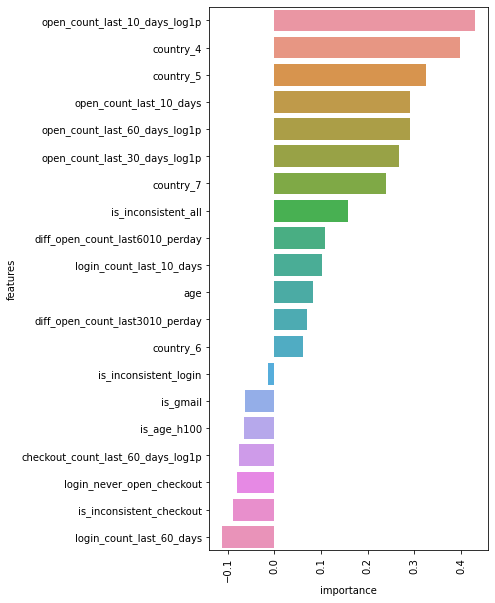

In [345]:
model = LogisticRegression(random_state=100, solver='newton-cg', n_jobs=-1, C=0.002)
model.fit(X,y)

data = {'features': features, 'importance':model.coef_.tolist()[0]}
dfx = pd.DataFrame(data)
dfx = dfx.sort_values(by='importance',ascending=False)
plt.figure(figsize=(5,10))
sns.barplot(y='features' , x='importance', data=dfx)
plt.xticks(rotation=90)

In [346]:
dfx

,features,importance
15,open_count_last_10_days_log1p,0.430228
7,country_4,0.398423
8,country_5,0.325111
0,open_count_last_10_days,0.290638
13,open_count_last_60_days_log1p,0.290435
14,open_count_last_30_days_log1p,0.267722
10,country_7,0.239173
5,is_inconsistent_all,0.158643
12,diff_open_count_last6010_perday,0.108086
1,login_count_last_10_days,0.101282


### Validate threshold

In [372]:
features = train.columns.tolist()
features.remove('open_flag')
target = 'open_flag'

### Find the best threshold
X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.15, stratify= train[target], random_state=300) # 404

# 50, 100, 150, 200, 250, 300

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((64621, 20), (11404, 20), (64621,), (11404,))

In [373]:
# model = LGBMClassifier(random_state=100)
model = LogisticRegression(random_state=100, solver='newton-cg', n_jobs=-1, C=0.002)
model = train_evaluate(model, X_train, X_val, y_train, y_val)
y_proba = model.predict_proba(X_val)

Evaluation Score
MMC  0.4910500924705515
Accuracy  0.8870571729217819
F1  0.527165932452276
Precision  0.720160481444333
Recall  0.4157498552403011


In [374]:
thresholds = []
f1s = []
recalls = []
precisions = []
mccs = []
for i in range(100):
    threshold = i*0.01
    vpredict = np.vectorize(lambda x: 1 if x > threshold else 0)
    y_pred = vpredict(y_proba[:,1])
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    mcc = matthews_corrcoef(y_val, y_pred)
    f1s.append(f1)
    thresholds.append(threshold)
    recalls.append(recall)
    precisions.append(precision)
    mccs.append(mcc)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


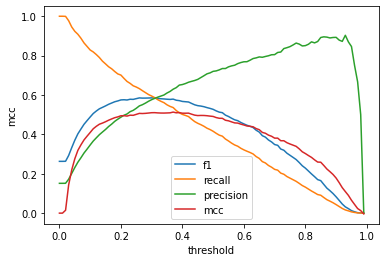

In [375]:
df_eval = pd.DataFrame({'threshold': thresholds, 'f1': f1s, 'recall': recalls, 'precision':precisions, 'mcc':mccs})
sns.lineplot(x="threshold",y="f1", data=df_eval, label="f1")
sns.lineplot(x="threshold",y="recall", data=df_eval, label="recall")
sns.lineplot(x="threshold",y="precision", data=df_eval, label="precision")
sns.lineplot(x="threshold",y="mcc", data=df_eval, label="mcc")
plt.legend()
plt.show()

In [376]:
df_eval6 = df_eval.copy()

In [405]:
df12 = pd.merge(df_eval1, df_eval2, how='left', on='threshold')
df12 = df12.rename(columns={'mcc_x':'mcc1', 'mcc_y':'mcc2'})
df123 = pd.merge(df12, df_eval3, how='left', on='threshold')
df123 = df123.rename(columns={'mcc':'mcc3'})
df1234 = pd.merge(df123, df_eval4, how='left', on='threshold')
df1234 = df1234.rename(columns={'mcc':'mcc4'})
df12345 = pd.merge(df1234, df_eval5, how='left', on='threshold')
df12345 = df12345.rename(columns={'mcc':'mcc5'})
df123456 = pd.merge(df12345, df_eval6, how='left', on='threshold')
df123456 = df123456.rename(columns={'mcc':'mcc6'})
df123456 = df123456[['threshold', 'mcc1', 'mcc2', 'mcc3', 'mcc4', 'mcc5', 'mcc6']]
df123456['avg_mcc'] = (df123456.mcc1 + df123456.mcc2 + df123456.mcc3 + df123456.mcc4 + df123456.mcc5 + df123456.mcc6) / 6

df123456.head()

,threshold,mcc1,mcc2,mcc3,mcc4,mcc5,mcc6,avg_mcc
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.02,0.003642,0.019801,0.017358,0.017707,0.007423,0.014571,0.013417
3,0.03,0.154514,0.154446,0.157758,0.150529,0.144622,0.143123,0.150832
4,0.04,0.219531,0.217054,0.215039,0.226006,0.223748,0.219181,0.220093


In [378]:
print("Max value of MCC ", df123456.avg_mcc.max())
print("The threshold ", df123456[df123456.avg_mcc == df123456.avg_mcc.max()]['threshold'])
# df_eval[df_eval.f1 == df_eval.f1.max()]['threshold']

Max value of MCC  0.5121244955002966
The threshold  29    0.29
Name: threshold, dtype: float64


In [379]:
df12 = pd.merge(df_eval1, df_eval2, how='left', on='threshold')
df12 = df12.rename(columns={'f1_x':'f11', 'f1_y':'f12'})
df123 = pd.merge(df12, df_eval3, how='left', on='threshold')
df123 = df123.rename(columns={'f1':'f13'})
df1234 = pd.merge(df123, df_eval4, how='left', on='threshold')
df1234 = df1234.rename(columns={'f1':'f14'})
df12345 = pd.merge(df1234, df_eval5, how='left', on='threshold')
df12345 = df12345.rename(columns={'f1':'f15'})
df123456 = pd.merge(df12345, df_eval6, how='left', on='threshold')
df123456 = df123456.rename(columns={'f1':'f16'})
df123456 = df123456[['threshold', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16']]
df123456['avg_f1'] = (df123456.f11 + df123456.f12 + df123456.f13 + df123456.f14 + df123456.f15 + df123456.f16) / 6

df123456.head()

,threshold,f11,f12,f13,f14,f15,f16,avg_f1
0,0.00,0.263042,0.263042,0.263042,0.263042,0.263042,0.263042,0.263042
1,0.01,0.263042,0.263042,0.263042,0.263042,0.263042,0.263042,0.263042
2,0.02,0.263078,0.263632,0.263511,0.263443,0.263178,0.263391,0.263372
3,0.03,0.297250,0.298888,0.299901,0.295351,0.293473,0.292751,0.296269
4,0.04,0.332755,0.332376,0.331022,0.334927,0.334525,0.332383,0.332998


In [380]:
print("Max value of MCC ", df123456.avg_f1.max())
print("The threshold ", df123456[df123456.avg_f1 == df123456.avg_f1.max()]['threshold'])
# df_eval[df_eval.f1 == df_eval.f1.max()]['threshold']

Max value of MCC  0.5879156350438804
The threshold  26    0.26
Name: threshold, dtype: float64


In [ ]:
df123456[df123456.avg_f1 == df123456.avg_f1.max()]

In [ ]:
print("Max value of MCC ", df_eval.mcc.max())
print("The threshold ", df_eval[df_eval.mcc == df_eval.mcc.max()]['threshold'])
# df_eval[df_eval.f1 == df_eval.f1.max()]['threshold']

In [ ]:
df_eval[df_eval.f1 == df_eval.f1.max()]

In [406]:
df123456.iloc[26,:]

threshold    0.260000
mcc1         0.516150
mcc2         0.501775
mcc3         0.487007
mcc4         0.520142
mcc5         0.529930
mcc6         0.506607
avg_mcc      0.510269
Name: 26, dtype: float64

In [ ]:
df_eval.iloc[37,:]

In [407]:
# Training in All dataset
# model = LGBMClassifier(random_state=100)
model = LogisticRegression(random_state=100, solver='newton-cg', n_jobs=-1, C=0.002)
model.fit(X,y)
y_proba = model.predict_proba(X_test)

# pick threhold
threshold = 0.26
vpredict = np.vectorize(lambda x: 1 if x > threshold else 0)
# convert probability to prediction based on threshold
y_pred = vpredict(y_proba[:,1])

### Submission

In [408]:
submission = pd.read_csv("../input/open-shopee-code-league-marketing-analytics/test.csv")
submission = submission[['row_id']]
submission['open_flag'] = y_pred
submission.to_csv("submission3.csv", index=False)
submission.head()

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [409]:
submission.open_flag.value_counts(normalize=True)
# first submission
# 0    0.911613
# 1    0.088387

# adjustment with first submission using best threshold
# 0    0.846989
# 1    0.153011

# first logreg using best threshold f1
# 0    0.825174
# 1    0.174826

# first logreg using best threshold mcc
# 0    0.867858
# 1    0.132142

0    0.831606
1    0.168394
Name: open_flag, dtype: float64